In [14]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import IBMQ, Aer, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_error_map
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss, L2Loss
from sklearn import preprocessing, svm
from sklearn.decomposition import PCA

os.environ["QISKIT_IN_PARALLEL"] = "TRUE"

In [15]:
SEED = 2508
random.seed(SEED)

In [5]:
# IBMQ.save_account('YOUR TOKEN HERE')
IBMQ.load_account()
provider = IBMQ.get_provider(
    hub="ibm-q-education", group="qscitech-quantum", project="qc-bc-workshop"
)

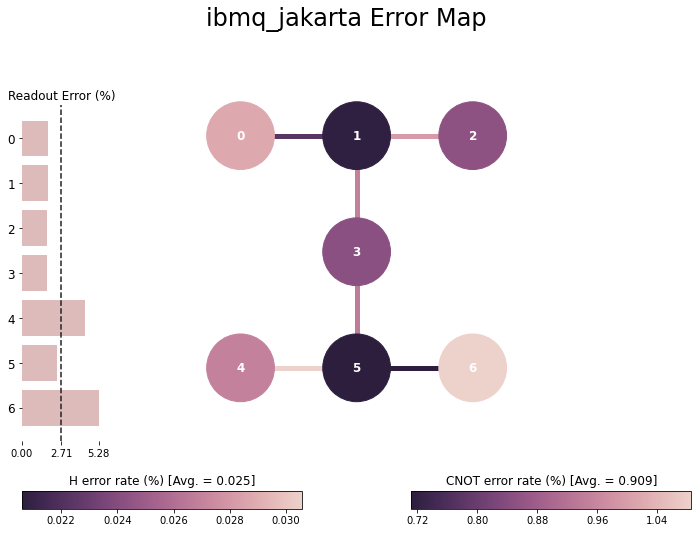

In [6]:
ibmq_jakarta = provider.get_backend("ibmq_jakarta")
plot_error_map(ibmq_jakarta)

# 1. Prepare (New) Dataset

**Dataset Information:**
* Total examples: 20,468 -- Dimensions: 112
* PCA down to: **4** dimensions
* Train set size: **100 (adjustable in cell below)**
* Test set size: **2,000 (adjustable in cell below)**

**Variables Information:**
* `x_train` [np.array] stores the train examples -- shape: (Train set size, 4)
* `y_train` [np.array] stores the train labels -- shape: (Train set size,)
* `x_test` [np.array] stores the test examples -- shape: (Test set size, 4)
* `y_test` [np.array] stores the train labels -- shape: (Test set size,)

**Note:** Run all cells in this section to generate the dataset variables

In [7]:
# set number of training and test example ---------------
n_examples = 100
n_test = 2000

In [9]:
# change the directory to the correct one on your machine
datafile = pd.read_csv("data/fraud_detection_bank_dataset.csv")
data = datafile.to_numpy()
datafile.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,9,1354,0,18,0,1,7,9,0,0,...,0,0,0,1,1,0,0,0,49,1
1,0,239,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,0,260,0,4,0,3,6,0,0,0,...,0,0,0,1,1,0,0,0,56,1
3,17,682,0,1,0,0,8,17,0,0,...,0,1,0,1,1,0,0,0,65,1
4,1,540,0,2,0,1,7,1,0,0,...,0,0,0,1,1,0,0,0,175,1


In [11]:
# Scale the features in the dataset, prior to PCA
X_data = data[:, :-1]
X_data = preprocessing.StandardScaler().fit_transform(X_data)

In [13]:
# PCA to reduce the number of features
pca = PCA(n_components=4, random_state=SEED)
X_pca = pca.fit_transform(X_data)
# Scale the features in the dataset, post PCA
X_pca = preprocessing.StandardScaler().fit_transform(X_pca)

In [17]:
n_class_train = int(n_examples / 2)
n_class_test = int(n_test / 2)

# 0 --> 3000 (pos train) ; 3000 --> 5438 (pos test)
# 5438 --> 18000 (neg train) ; 18000 --> 20468 (neg test)
rand_pos_ind = random.sample(range(0, 3000), n_class_train)
rand_neg_ind = random.sample(range(5438, 18000), n_class_train)
x_train = np.concatenate((X_pca[rand_pos_ind], X_pca[rand_neg_ind]))
y_train = (
    np.concatenate((np.ones((n_class_train, 1)), np.zeros((n_class_train, 1))))
    .astype(int)
    .reshape(
        n_examples,
    )
)

rand_pos_ind = random.sample(range(3000, 5438), n_class_test)
rand_neg_ind = random.sample(range(18000, 20468), n_class_test)
x_test = np.concatenate((X_pca[rand_pos_ind], X_pca[rand_neg_ind]))
y_test = (
    np.concatenate((np.ones((n_class_test, 1)), np.zeros((n_class_test, 1))))
    .astype(int)
    .reshape(
        n_test,
    )
)

# compatibility with previous implementation
x_train_norm = x_train
x_test_norm = x_test

# 2. VQC from scratch

## 2.1. Prepare encoders and ansatz

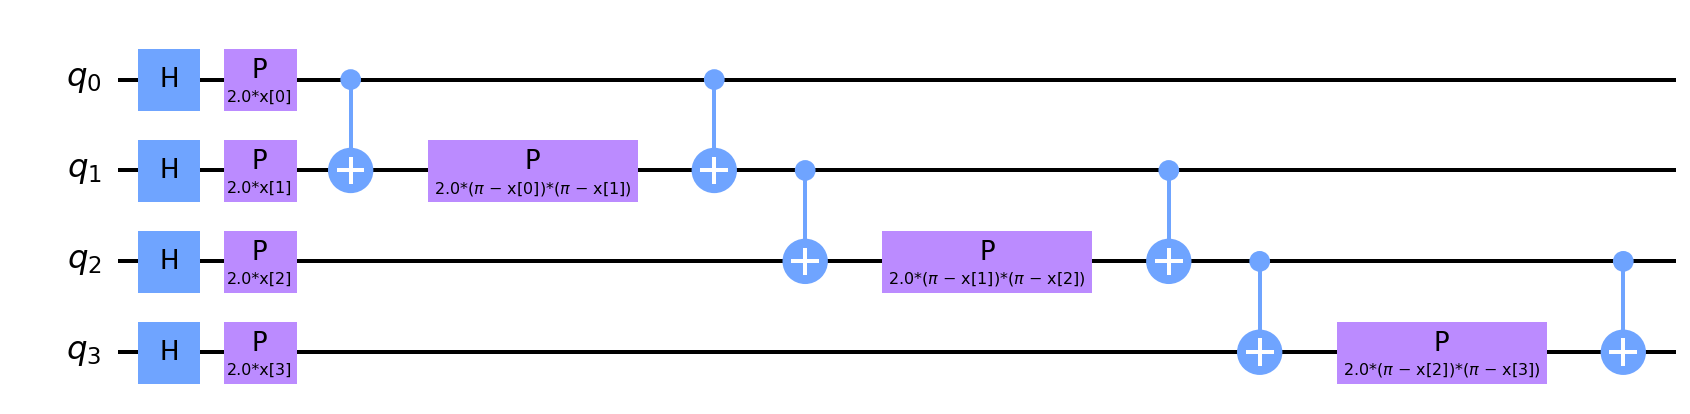

In [18]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(
        feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent
    )


feature_dim = 4
fmap_zz = get_zz_feature_map(feature_dim, 1, "linear")
fmap_zz.decompose().draw("mpl", scale=2)

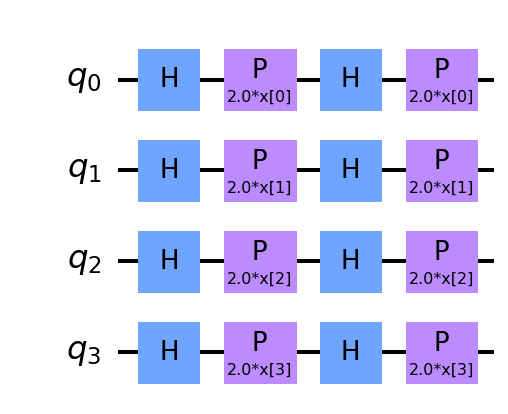

In [19]:
def get_z_feature_map(feature_dim, feature_map_rep):
    return ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep)


fmap_z = get_z_feature_map(feature_dim, 2)
fmap_z.decompose().draw("mpl", scale=2)

x, ['x[0]', 'x[1]', 'x[2]', 'x[3]']


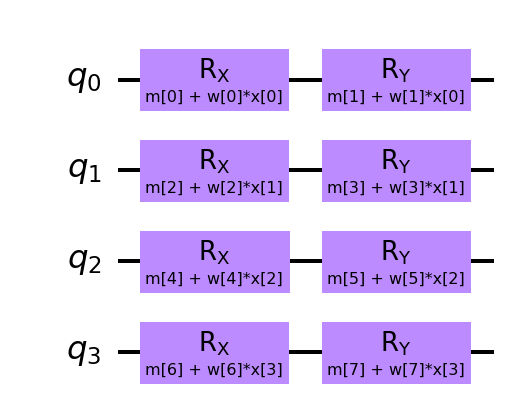

In [20]:
# Define angle embedding with weights
def get_angle_embedding(nb_features, repeat=1):
    x_params = ParameterVector("x", nb_features)
    weight_params = ParameterVector("w", 2 * nb_features * repeat)
    rotation_params = ParameterVector("m", 2 * nb_features * repeat)

    model_params = list(rotation_params) + list(weight_params)

    qc = QuantumCircuit(nb_features)
    for j in range(repeat):
        for i in range(nb_features):
            qc.rx(
                x_params[i] * weight_params[2 * i + 2 * nb_features * j]
                + rotation_params[2 * i + 2 * nb_features * j],
                i,
            )
            qc.ry(
                x_params[i] * weight_params[2 * i + 2 * nb_features * j + 1]
                + rotation_params[2 * i + 2 * nb_features * j + 1],
                i,
            )

    return qc, x_params, model_params


repeat = 1
angle_embedding, x_params, m_params = get_angle_embedding(feature_dim, repeat)
print(x_params)
angle_embedding.draw("mpl", scale=2)

In [21]:
# Define function(s) to generate the encoder circuit
# TODO: implement different designs for data encoding (one function for each)
def encoder_circuit_1(data_x, _):
    """
    Args:
        data_x [np.array] : one data example
        (...)
    Returns:
        encoder_circuit [QuantumCircuit] : encoder circuit for input data example
    """
    encoder_circuit = None
    return encoder_circuit


## 2.2. Prepare Ansatz

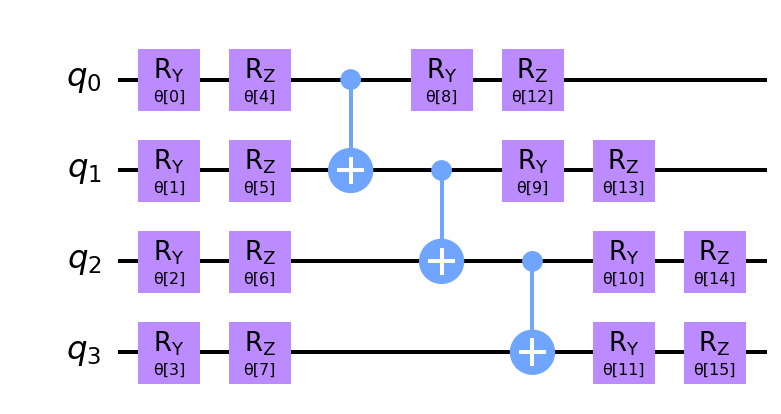

In [22]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(
        num_qubits=feature_dim,
        rotation_blocks=rotations,
        entanglement_blocks="cx",
        entanglement=ent,
        reps=var_form_rep,
    )


ansatz_tl = get_two_locals(feature_dim, ["ry", "rz"], 1, "linear")
ansatz_tl.decompose().draw("mpl", scale=2)

In [23]:
# Define function(s) to generate the ansatz
# TODO: implement different ansatz designs (one function for each)
def ansatz_1(n_qubits, _):
    """
    Args:
        n_qubits [int] : number of qubits in the circuit
        (...other necessary args -- e.g., n_layers)
    Returns:
        ansatz [QuantumCircuit] : parameterized ansatz circuit
        ansatz_params [ParameterVector] : parameter vector of the ansatz
    """
    ansatz = None
    ansatz_params = None
    return ansatz, ansatz_params


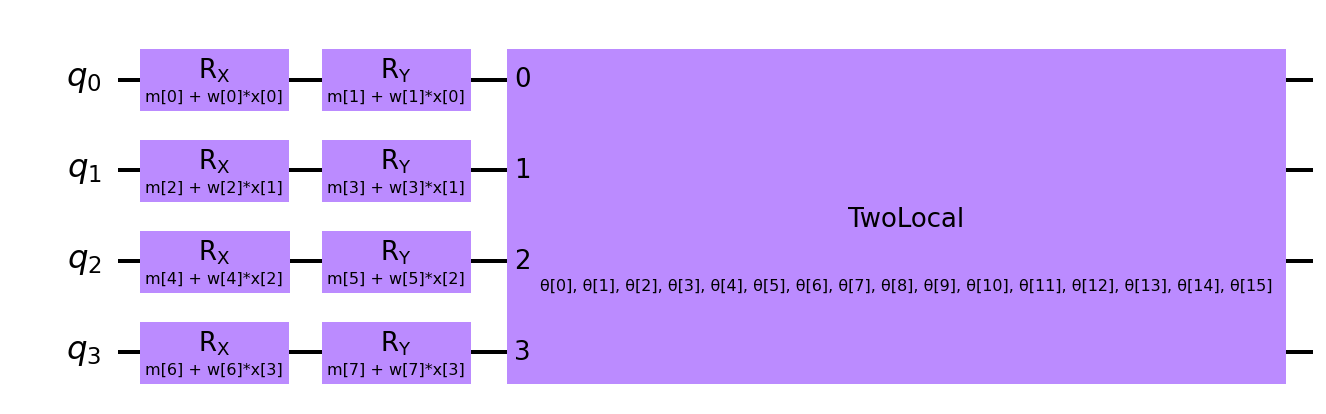

In [24]:
var_circuit = angle_embedding.compose(ansatz_tl)
var_circuit.draw("mpl", scale=2)

In [25]:
# TODO: Define function to generate all data encoder circuits (one for each example in the dataset)
# Preparing and cache all encoder circuits to concatenate with ansatz later
def get_all_encoders(data_mat, encoder_func, _):
    """
    Args:
        data_mat [np.array] : of shape (n_samples,n_features) -- matrix containing all examples
        encoder_func [function] : callable to generate encoder circuit (e.g., encoder_circuit_1)
        (...)
    Returns:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
    """
    all_encoders = []
    # pseudo-code: for 'example' in 'data_mat': all_encoders.append(encoder_func('example'))
    return all_encoders


In [26]:
# TODO: Define function to generate all VQC circuits (one for each example)
def get_all_circuits(all_encoders, ansatz_func, _):
    """
    Args:
        all_encoders [list(QuantumCircuit)] : list of all encoder circuits (one for each example)
        ansatz_func [function] : callable to generate ansatz circuit (e.g., ansatz_1)
        (...)
    Returns:
        all_circuits [list(QuantumCircuit)] : list of all VQC circuits (one for each example)
    """
    all_circuits = []
    return all_circuits


In [27]:
# Create a quantum instance to wrap the execution of circuits
qinstVQC = QuantumInstance(Aer.get_backend("statevector_simulator"))

In [28]:
# TODO: Define function to calculate target values (can be expectation value or sampling probability)
def get_all_target_vals(all_results, _):
    """
    Args:
        all_results [Result] : output wrapper of all results from executing the VQC circuits
        (...)
    Returns:
        target_val [list(float)] : target values for classification (e.g., expectation value), one for each example
    """
    target_vals = []
    return target_vals


In [29]:
# TODO: Define function to calculate cost function given all target vals (there can be multiple designs for cost function)
def calculate_cost_function(target_vals, true_labels, _):
    """
    Args:
        target_vals [list(float)] : target values for classification (e.g., expectation value), one for each example
        true_labels [np.array] : vector containing true labels for each example (0 or 1)
        (...)
    Returns:
        cost [float] : total cost for current instance
    """
    cost = 0
    return cost


## 2.3 Prepare measurement

In [30]:
# for multi-class problem this works
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes


# for multi-class problem this needs to be changed
def one_qubit_binary(x):
    return x % 2


# 3. VQC using Qiskit QNN Classes

In [31]:
qasm_sim = Aer.get_backend("qasm_simulator")
qinst_qasm = QuantumInstance(qasm_sim, 2048)

## 3.1. Circuit QNN

In [32]:
num_classes = 2
qnn = CircuitQNN(
    circuit=var_circuit,
    # input_params=fmap_z.parameters,
    # input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit
    input_params=x_params,  # (e.g. amplitude encoding) you will have to do some extra work!
    # weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
    weight_params=list(ansatz_tl.parameters)
    + list(m_params),  # parameters of the embedding must be added
    interpret=one_qubit_binary,
    output_shape=num_classes,
    gradient=None,
    quantum_instance=qinst_qasm,
)

In [33]:
# to run on hardware
phys_qubits = [3, 4, 5, 6]
N_shots = 2048
qinst_hardware = QuantumInstance(
    ibmq_jakarta, shots=N_shots, initial_layout=phys_qubits
)

In [34]:
qnn_hardware = CircuitQNN(
    circuit=var_circuit,
    # input_params=fmap_z.parameters,
    # input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit
    input_params=x_params,  # (e.g. amplitude encoding) you will have to do some extra work!
    weight_params=list(ansatz_tl.parameters)
    + list(m_params),  # if you train your embedding as well, the trainable
    # parameters of the embedding must be added
    interpret=one_qubit_binary,
    output_shape=num_classes,
    gradient=None,
    quantum_instance=qinst_hardware,
)

### Forward pass

In [35]:
# The result of the neural network of the shape (output_shape).
weights = np.random.random(len(list(ansatz_tl.parameters) + list(m_params)))

output = qnn.forward(x_train[1], weights)
print(output.shape)
output

(1, 2)


array([[0.56933594, 0.43066406]])

### Backward pass

In [36]:
_, update = qnn.backward(x_train[0], weights)
print(update)
print(update.shape)

[[[-0.26660156 -0.02856445  0.01513672  0.00195313 -0.13745117
   -0.08520508  0.01123047 -0.0012207  -0.25854492 -0.00341797
    0.00439453  0.00512695 -0.00170898 -0.00585937  0.01098633
    0.00683594  0.07373047 -0.26538086  0.06420898 -0.03076172
   -0.00097656  0.00585937 -0.01147461 -0.00268555 -0.01176617
    0.04727631  0.05263531 -0.01551357  0.00290943 -0.00187496
    0.00081786  0.00056621]
  [ 0.26660156  0.02856445 -0.01513672 -0.00195312  0.13745117
    0.08520508 -0.01123047  0.0012207   0.25854492  0.00341797
   -0.00439453 -0.00512695  0.00170898  0.00585938 -0.01098633
   -0.00683594 -0.07373047  0.26538086 -0.06420898  0.03076172
    0.00097656 -0.00585938  0.01147461  0.00268555  0.01176617
   -0.04727631 -0.05263531  0.01551357 -0.00290943  0.00187496
   -0.00081786 -0.00056621]]]
(1, 2, 32)


### 3.1.1. Prepare encoder, ansatz, and interpreter

In [37]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [
        (np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(
            len(unique_labels)
        )
        for y_i in y
    ]

    return np.array(y_one_hot)


y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [39]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f"{nfev} - {fval}")

### 3.1.2. Training Implementation

In [41]:
from qiskit.algorithms.optimizers import ADAM, COBYLA, SLSQP, SPSA

max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(list(ansatz_tl.parameters) + list(m_params)),))
vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss=CrossEntropyLoss(),  # log of ...
    one_hot=True,
    optimizer=spsa_opt,
    initial_point=initial_point,
)

x_train_norm = np.array(
    [x / np.linalg.norm(x) for x in x_train]
)  # normalizing or not ... can depend on the data set you can try both
vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 120.9675367684064
6 - 110.41099343447249
9 - 104.32639069281649
12 - 103.38875634756047
15 - 103.20447086647533
18 - 102.7086822360657
21 - 100.12887927395667
24 - 99.70427550646863
27 - 98.54615044688762
30 - 99.18955569291809
33 - 98.03722983278921
36 - 98.74356558897485
39 - 98.4993566281412
42 - 98.75725112122332
45 - 98.92299851933859
48 - 98.11345082433431
51 - 98.21914376188953
54 - 98.31074068996598
57 - 98.54156444410944
60 - 98.16944624559784
63 - 98.09346694503775
66 - 98.11671747563342
69 - 99.112236710191
72 - 98.20524459594965
75 - 98.2062916880382
78 - 99.06799648349386
81 - 97.94350566214148
84 - 98.51413793553579
87 - 97.80320285536989
90 - 97.81361556992749
93 - 98.60455662591988
96 - 98.11264723889698
99 - 98.21588786390699
102 - 97.62394185169356
105 - 98.86300023490145
108 - 98.35614444286038
111 - 98.33380922693485
114 - 98.12644568997065
117 - 97.86932178229902
120 - 98.73294704474003
123 - 97.83115612239523
126 - 97.91148820159388
129 - 98.1438858515204
132 

In [ ]:
# to run on hardware
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(list(ansatz_tl.parameters) + list(m_params)),))
vqc = NeuralNetworkClassifier(
    neural_network=qnn_hardware,
    loss=CrossEntropyLoss(),  # log of ...
    one_hot=True,
    optimizer=spsa_opt,
    initial_point=initial_point,
)

x_train_norm = np.array(
    [x / np.linalg.norm(x) for x in x_train]
)  # normalizing or not ... can depend on the data set you can try both
vqc = vqc.fit(x_train_norm, y_train_1h)

/Users/nate/opt/anaconda3/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:727: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)


In [ ]:
score_train_norm = vqc.score(x_train_norm, y_train_1h)
print(f"Score on the normalized train set {score_train_norm}")

x_test_norm = np.array(
    [x / np.linalg.norm(x) for x in x_test]
)  # normalizing or not ... can depend on the data set you can try both
score_test_norm = vqc.score(x_test_norm, y_test_1h)
print(f"Score on the normalized test set {score_test_norm}")

In [ ]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

## 3.2. Opflow QNN

### 3.2.1. Define measurement operator and circuit state function

In [64]:
from qiskit.opflow import StateFn, Gradient, I, Z

In [65]:
obs_parity = Z ^ feature_dim
obs_one_qubit = I ^ (feature_dim - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

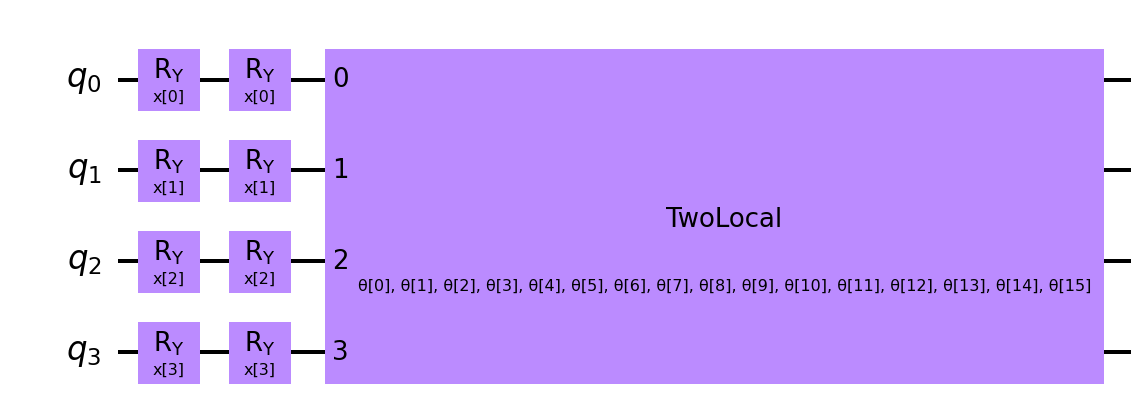

In [66]:
mymap_op = get_my_map(feature_dim, 2)
var_circuit_op = mymap_op.compose(ansatz_tl)
var_circuit_op.draw("mpl", scale=2)

In [67]:
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit_op)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002034FA53610>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [68]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(
    operator,
    # input_params=fmap_z_op.parameters,
    input_params=mymap_op.parameters,
    weight_params=ansatz_tl.parameters,
    gradient=gradient,
    quantum_instance=qinst_qasm,
)

### Forward pass

In [69]:
weights = np.random.random(len(ansatz_tl.parameters))
output = op_qnn.forward(x_train[0], weights)
print(output.shape)

(1, 1)


### Backward pass

In [64]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 16)


array([[[-0.46582031, -0.00732422, -0.00390625,  0.01757813,
          0.04003906,  0.00878906, -0.01855469,  0.00830078,
         -0.83789062,  0.02880859,  0.00732422,  0.01318359,
         -0.00683594, -0.01318359, -0.00244141, -0.01220703]]])

### 3.1.2. Training Implementation

In [42]:
from qiskit.algorithms.optimizers import GradientDescent

In [43]:
y_train_pm = np.array([-1 if y==0 else y for y in y_train])
y_test_pm = np.array([-1 if y==0 else y for y in y_test])
y_train.shape

(100,)

In [72]:
max_itr = 30
gd_opt = GradientDescent(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
op_vqc = NeuralNetworkClassifier(
    neural_network=op_qnn,
    loss=L2Loss(),
    one_hot=False,
    optimizer=gd_opt,
    initial_point=initial_point,
)

op_vqc = op_vqc.fit(x_train, y_train_pm)

1 - 109.27603054046631
2 - 108.25804901123047
3 - 106.33079814910889
4 - 104.87362766265869
5 - 101.9281587600708
6 - 97.71057415008545
7 - 90.23495197296143
8 - 83.41075992584229
9 - 80.60181045532227
10 - 79.26840400695801
11 - 79.95791816711426
12 - 80.30300807952881
13 - 80.20854091644287
14 - 79.80421257019043
15 - 79.60912609100342
16 - 79.73513221740723
17 - 79.49081230163574
18 - 79.88297939300537
19 - 79.32025814056396
20 - 80.02000522613525
21 - 79.58462333679199
22 - 78.97389793395996
23 - 79.08813285827637
24 - 79.29561614990234
25 - 79.15980339050293
26 - 79.86717987060547
27 - 78.74774742126465
28 - 79.38510417938232
29 - 78.82346248626709
30 - 79.52055835723877


In [73]:
score_train = op_vqc.score(x_train, y_train_pm)
score_test = op_vqc.score(x_test, y_test_pm)
print(f"Score on the train set {score_train}")
print(f"Score on the test set {score_test}")

Score on the train set 0.5125
Score on the test set 0.65


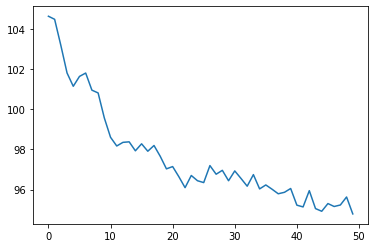

In [36]:
plt.plot(loss_recorder)

### 3.1.3. Results Discussion

# 4. Quantum Support Vector Machine (if have time)

## 4.1. Define feature map(s) (kernel)

In [39]:
qinst_kernel = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))

In [ ]:
# ZZ-featureMap
def ZZ_kernel(
    feature_dim, reps, quantum_instance, entanglement="linear", insert_barriers=False
):
    ZZ_map = ZZFeatureMap(
        feature_dimension=feature_dim,
        reps=reps,
        entanglement=entanglement,
        insert_barriers=insert_barriers,
    )
    ZZ_kernel = QuantumKernel(ZZ_map, quantum_instance=quantum_instance)
    return ZZ_kernel

In [ ]:
kernel = ZZ_kernel(feature_dim, reps=1, quantum_instance=qinst_kernel)
kernel.feature_map.decompose().draw("mpl")

In [ ]:
# custom kernel inspired by Xiaoran's design, with linear entanglement
def custom_kernel(feature_dim, reps, quantum_instance, insert_barriers=False):
    qc = QuantumCircuit(feature_dim)
    data_params = ParameterVector("x", feature_dim)
    for layer in range(reps):
        for i in range(feature_dim):
            qc.ry(data_params[i], i)
            qc.rz(data_params[i], i)
        for i in range(feature_dim - 1):
            qc.cx(i, i + 1)
        if insert_barriers:
            qc.barrier()
    kernel = QuantumKernel(feature_map=qc, quantum_instance=quantum_instance)
    return kernel

In [ ]:
my_kernel = custom_kernel(
    feature_dim=feature_dim, reps=2, quantum_instance=qinst_kernel, insert_barriers=True
)
my_kernel.feature_map.draw("mpl")

## 4.2. Training Implementation (using sci-kit's SVC class)

### 4.2.1. Training with ZZ-FeatureMap

In [ ]:
kernel_ZZ = ZZ_kernel(
    feature_dim=feature_dim, reps=1, quantum_instance=qinst_kernel, insert_barriers=True
)
display(kernel_ZZ.feature_map.decompose().draw("mpl"))

In [ ]:
qclf_ZZ = svm.SVC(kernel=kernel_ZZ.evaluate)

In [ ]:
qclf_ZZ.fit(x_train_norm, y_train)

In [ ]:
print(f"Training accuracy: {qclf_ZZ.score(x_train_norm,y_train)}")

In [ ]:
print(f"Test accuracy: {qclf_ZZ.score(x_test_norm,y_test):.3f}")

### 4.2.2. Training with custom feature map

In [ ]:
kernel_custom = custom_kernel(
    feature_dim=feature_dim, reps=1, quantum_instance=qinst_kernel, insert_barriers=True
)
display(kernel_custom.feature_map.draw("mpl"))

In [ ]:
qclf_custom = svm.SVC(kernel=kernel_custom.evaluate)

In [ ]:
qclf_custom.fit(x_train_norm, y_train)

In [ ]:
print(f"Training accuracy: {qclf_custom.score(x_train_norm,y_train):.3f}")

In [ ]:
print(f"Test accuracy: {qclf_custom.score(x_test_norm,y_test):.3f}")

## 4.3. Results Discussion

# 5. Classical Methods (if have time)

## 5.1. Classical SVM

In [ ]:
clf_linear = svm.SVC(kernel="linear")
clf_linear.fit(x_train_norm, y_train)
print(
    f"Training accuracy: {clf_linear.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_linear.score(x_test_norm,y_test):.3f}"
)

In [ ]:
clf_poly = svm.SVC(kernel="poly", degree=3)
clf_poly.fit(x_train_norm, y_train)
print(
    f"Training accuracy: {clf_poly.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_poly.score(x_test_norm,y_test):.3f}"
)

In [ ]:
clf_rbf = svm.SVC(kernel="rbf")
clf_rbf.fit(x_train_norm, y_train)
print(
    f"Training accuracy: {clf_rbf.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_rbf.score(x_test_norm,y_test):.3f}"
)

## 5.2. Classical Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

### 5.2.1. ANN w/ 1 Hidden Layer (20) -- ReLU activation

In [ ]:
clf_nn = MLPClassifier(
    solver="adam",
    hidden_layer_sizes=(20,),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn.n_iter_} iterations")

In [ ]:
print(
    f"Training accuracy: {clf_nn.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn.score(x_test_norm,y_test):.3f}"
)

### 5.2.2. ANN w/ 2 Hidden Layers (20,20) -- ReLU activation

In [ ]:
clf_nn_2 = MLPClassifier(
    solver="adam",
    hidden_layer_sizes=(20, 20),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn_2.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn_2.n_iter_} iterations")

In [ ]:
print(
    f"Training accuracy: {clf_nn_2.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn_2.score(x_test_norm,y_test):.3f}"
)

### 5.2.3. ANN w/ 1 Hidden Layer (20) -- Sigmoid activation

In [ ]:
clf_nn_sig = MLPClassifier(
    solver="adam",
    activation="logistic",
    hidden_layer_sizes=(20,),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn_sig.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn_sig.n_iter_} iterations")

In [ ]:
print(
    f"Training accuracy: {clf_nn_sig.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn_sig.score(x_test_norm,y_test):.3f}"
)

### 5.2.2. ANN w/ 2 Hidden Layers (20,20) -- Sigmoid activation

In [ ]:
clf_nn_sig_2 = MLPClassifier(
    solver="adam",
    activation="logistic",
    hidden_layer_sizes=(20, 20),
    learning_rate="adaptive",
    random_state=1,
    max_iter=10000,
)
clf_nn_sig_2.fit(x_train_norm, y_train)
print(f"Converged after {clf_nn_sig_2.n_iter_} iterations")

In [ ]:
print(
    f"Training accuracy: {clf_nn_sig_2.score(x_train_norm,y_train):.3f}\n"
    + f"Testing accuracy: {clf_nn_sig_2.score(x_test_norm,y_test):.3f}"
)